In [245]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from tqdm import tqdm

# Solve the ODEs using hard constraints

We consider the first-order ODE: $$\frac{d\psi}{dx} = f(x, \psi)$$

 The trial solutioncan can be wirtten as:  $$\psi_t = A(x) + G(x)N(x, p)$$

where $A(x)$ and $G(x)$ are constant functions for boundary conditions, they are determined by boundary conditions(Dirichlet or Neumann). $N(x, p)$ is a single-output feedforward neural network with parameters $p$, and $x$ is the input, $p$ is the parameter of the neural network.
Then we just minimize the following function: $[\frac{d\psi_t}{dx} - f(x, \psi)]^2$



## Problem 1 

In this problem, the ODE is $$\frac{d\psi}{dx} + (x + \frac{1 + 3 x^2}{1 + x + x^3})  \psi = x^3 + 2  x + x^2  \frac{1 + 3  x^2}{1 + x + x^3}$$

with $\psi(0) = 1$, and $x \in [0, 1]$. So $A(x) = 1$, $G(x) = x$, $f(x, \psi) = x^3 + 2  x + x^2  \frac{1 + 3  x^2}{1 + x + x^3} - (x + \frac{1 + 3 x^2}{1 + x + x^3})  \psi$. Finally,  we can obtain $\psi_t = 1 + xN(x, p)$.

And the analytical solution is $\psi(x) = \frac{e^{-x^2/2}}{1+x+x^3} + x^2$. 

In [246]:
def A(x):
    """boundary condition: psi(0) = 1"""
    return 1.


def G(x):
    """source term: G(x) = x"""
    return x


class NeuralNetwork(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.input_dim = input_dim # input dimension
        self.net = nn.Sequential(
            nn.Linear(self.input_dim, 32),
            nn.SiLU(),
            nn.Linear(32, 256),
            nn.SiLU(),
            nn.Linear(256,32),
            nn.SiLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)


def trial_solution_psi(x, network):
    """trial solution: Ψ_t = A(x) + G(x) * N(x, p)
    :x: 1D tensor
    :network: neural network
    """
    return A(x) + G(x) * network(x)

In [247]:

def f(x, psi):
    """ 
    dpsi_t / dx = f(x, psi_t)
    f(x, psi_t) = x**3 + 2 * x + x**2 * (1 + 3 * x**2) / (1 + x + x**3) - (x + (1 + 3 * x**2) / (1 + x + x**3)) * psi
    :x: 1D tensor of x values, input
    :psi: psi_t
    """
    return x**3 + 2 * x + x**2 * (1 + 3 * x**2) / (1 + x + x**3) - (x + (1 + 3 * x**2) / (1 + x + x**3)) * psi

def calculate_loss(network, num_collocation_points=100):
    """
    compute the MSE loss for PINN
    x in [0, 1]
    :network: Neural network
    :num_collocation_points: number of collocation points
    """
    
    x_collocation = torch.linspace(0, 1, num_collocation_points, requires_grad=True).reshape(-1, 1)
    psi_t = trial_solution_psi(x_collocation, network)
    d_psi_dx = torch.autograd.grad(psi_t, x_collocation, grad_outputs=torch.ones_like(psi_t), create_graph=True)[0]
    

    residual = d_psi_dx - f(x_collocation, psi_t)
    loss = torch.mean(residual**2)
    
    return loss


In [248]:
def plot_results(x, y_true, y_pred):
    """plot the results of PINN , exact solution and error (error = y_pred - y_true)
    :x: X-axis data
    y_true: Exact solution
    y_pred: PINN solution
    """

    error = y_pred - y_true

    fig, (ax_main, ax_error) = plt.subplots(2, 1, sharex=True, figsize=(7, 6), gridspec_kw={'height_ratios': [2.5, 1]})


    ax_main.tick_params(axis='both', which='both', top=True, right=True, direction='in')
    ax_main.plot(x, y_pred, color='black', label='PINN Solution', linewidth=1)
    ax_main.scatter(x, y_true, s=2, c='red', label='Exact Solution')
    ax_main.set_ylabel('$\psi(x)$')
    ax_main.grid(False)
    ax_main.legend(frameon=False)

    ax_error.tick_params(axis='both', which='both', top=True, right=True, direction='in')
    ax_error.plot(x, error, color='black',linestyle='--', label='Error', linewidth=1)
    ax_error.set_xlabel('x')
    ax_error.set_ylabel('Error')
    ax_error.grid(False)
    ax_error.legend(frameon=False)

    fig.subplots_adjust(hspace=0)
    #plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


<>:16: SyntaxWarning: invalid escape sequence '\p'
<>:16: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_1115851/1908471137.py:16: SyntaxWarning: invalid escape sequence '\p'
  ax_main.set_ylabel('$\psi(x)$')


In [249]:
def train(epochs, model, optimizer, scheduler):
    for epoch in tqdm(range(epochs)):
        optimizer.zero_grad()
        loss = calculate_loss(model)
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        if (epoch + 1) % 500 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.6f}")


In [250]:
pinn_net = NeuralNetwork(input_dim=1)
optimizer = torch.optim.Adam(pinn_net.parameters(), lr=1e-2) 
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10000, gamma=0.9) #Optimizes learning rate based on the number of epochs

In [251]:
train(epochs=5000, model=pinn_net, optimizer=optimizer, scheduler=scheduler)

 11%|█         | 552/5000 [00:01<00:10, 426.44it/s]

Epoch [500/5000], Loss: 0.000039


 21%|██        | 1049/5000 [00:02<00:09, 408.36it/s]

Epoch [1000/5000], Loss: 0.000012


 32%|███▏      | 1582/5000 [00:03<00:08, 398.84it/s]

Epoch [1500/5000], Loss: 0.000010


 42%|████▏     | 2077/5000 [00:05<00:07, 417.28it/s]

Epoch [2000/5000], Loss: 0.000257


 51%|█████     | 2545/5000 [00:06<00:05, 421.50it/s]

Epoch [2500/5000], Loss: 0.000009


 61%|██████▏   | 3065/5000 [00:07<00:04, 431.24it/s]

Epoch [3000/5000], Loss: 0.000007


 72%|███████▏  | 3580/5000 [00:08<00:03, 425.96it/s]

Epoch [3500/5000], Loss: 0.000007


 81%|████████  | 4058/5000 [00:10<00:02, 431.74it/s]

Epoch [4000/5000], Loss: 0.000006


 91%|█████████▏| 4570/5000 [00:11<00:01, 425.69it/s]

Epoch [4500/5000], Loss: 0.000012


100%|██████████| 5000/5000 [00:12<00:00, 406.07it/s]

Epoch [5000/5000], Loss: 0.000002


The range of pinn training is in [0, 1], while the range we ultimately use for plotting and comparison is in [0, 2].

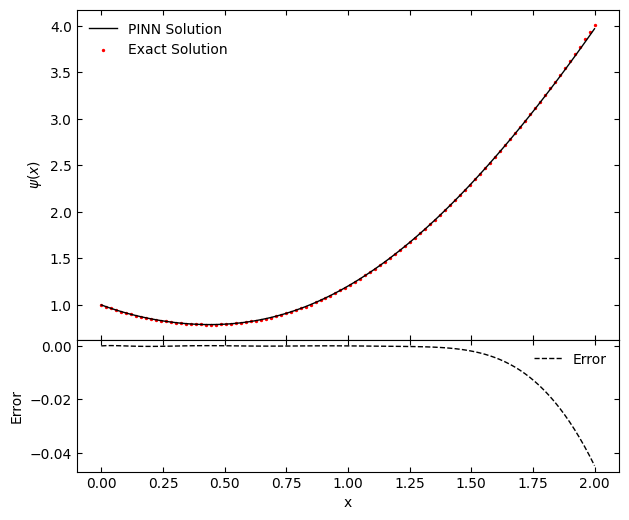

In [252]:
x_test = torch.linspace(0, 2, 100).view(-1, 1) #the range of the plotting 

def psi_exact(x):
    """Exact solution: psi(x) = exp(-x^2/2) / (1 + x + x^3) + x^2"""
    return np.exp(-x**2 / 2) / (1 + x + x**3) + x**2

psi_true = psi_exact(x_test.numpy())

# switch to evaluate mode
pinn_net.eval()
with torch.no_grad():
    psi_pred = trial_solution_psi(x_test, pinn_net)

# plot the results
plot_results(x_test.numpy(), psi_true, psi_pred.numpy())

## Problem 2

The ODE is $$\frac{d}{dx}\psi + \frac{1}{5}\psi = e^{-\frac{x}{5}}\cos{x}$$

with $\psi(0) = 0$, and $x \in [0, 2]$. So $A(x) = 0$, $G(x) = x$, $f(x, \psi) = e^{-\frac{x}{5}}\cos{x} - \frac{1}{5}\psi$. Finally,  we can obtain $\psi_t = xN(x, p)$.

And the analytical solution is $\psi(x) = e^{-\frac{x}{5}}\sin{x}$. 

In [253]:
def A(x):
    return 0

def G(x):
    return x

def f(x, psi):
    return torch.exp(-x/5) * torch.cos(x) - 0.2 * psi

def calculate_loss(network, num_collocation_points=200):
    """
    compute the MSE loss for PINN
    x = [0, 2]
    """
    
    x_collocation = torch.linspace(0, 2, num_collocation_points, requires_grad=True).reshape(-1, 1)
    psi_t = trial_solution_psi(x_collocation, network)
    d_psi_dx = torch.autograd.grad(psi_t, x_collocation, grad_outputs=torch.ones_like(psi_t), create_graph=True)[0]
    

    residual = d_psi_dx - f(x_collocation, psi_t)
    loss = torch.mean(residual**2)
    
    return loss

In [254]:
pinn_net = NeuralNetwork(input_dim=1)
optimizer = torch.optim.Adam(pinn_net.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10000, gamma=0.9)

In [255]:
train(epochs=5000, model=pinn_net, optimizer=optimizer, scheduler=scheduler)

 11%|█▏        | 574/5000 [00:01<00:09, 446.94it/s]

Epoch [500/5000], Loss: 0.000002


 21%|██        | 1057/5000 [00:02<00:09, 419.71it/s]

Epoch [1000/5000], Loss: 0.000001


 31%|███       | 1557/5000 [00:03<00:08, 414.81it/s]

Epoch [1500/5000], Loss: 0.000001


 41%|████▏     | 2067/5000 [00:05<00:07, 396.53it/s]

Epoch [2000/5000], Loss: 0.000001


 51%|█████▏    | 2565/5000 [00:06<00:06, 376.22it/s]

Epoch [2500/5000], Loss: 0.000000


 61%|██████    | 3062/5000 [00:07<00:04, 388.72it/s]

Epoch [3000/5000], Loss: 0.000000


 71%|███████   | 3548/5000 [00:08<00:03, 440.21it/s]

Epoch [3500/5000], Loss: 0.000000


 81%|████████▏ | 4072/5000 [00:10<00:02, 427.58it/s]

Epoch [4000/5000], Loss: 0.000000


 91%|█████████ | 4559/5000 [00:11<00:01, 435.42it/s]

Epoch [4500/5000], Loss: 0.000000


100%|██████████| 5000/5000 [00:12<00:00, 410.38it/s]


Epoch [5000/5000], Loss: 0.000000


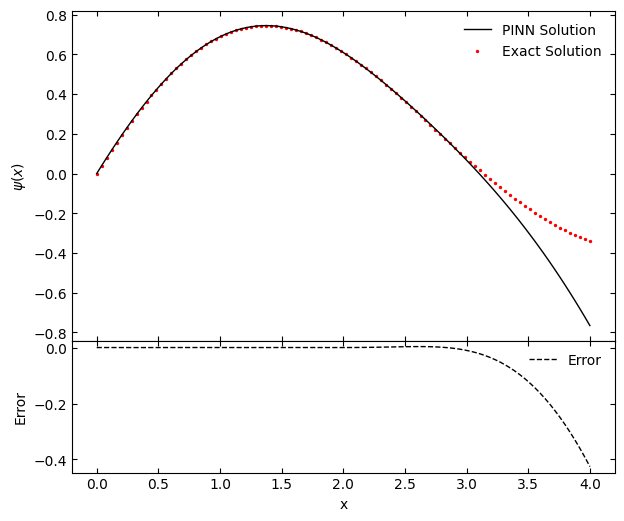

In [256]:
x_test = torch.linspace(0, 4, 100).view(-1, 1)

def psi_exact(x):
    """Exact solution: psi(x) = exp(-x/5) / cos(x)"""
    return np.exp(-x / 5) * np.sin(x)

psi_true = psi_exact(x_test.numpy())

# switch to evaluate mode
pinn_net.eval()
with torch.no_grad():
    psi_pred = trial_solution_psi(x_test, pinn_net)

# plot the results
plot_results(x_test.numpy(), psi_true, psi_pred.numpy())

# Solve the PDEs using hard constraints

We treat here two-dimensional problems only. 
$$\nabla^2 \psi = f(x,y,\psi,\nabla \psi)$$

$x \in [0, 1]$, $y \in [0, 1]$ with Dirichlet boundary conditions: $\psi(0, y) = f_0(y)$ and $\psi(1, y) = f_1(y)$ and $\psi(x, 0) = g_0(x)$ and $\psi(x, 1) = g_1(x)$. The trial solution is witten as:
$$\psi_t(x, y) = A(x, y) + B(x, y)N(x, y, p)$$

where $A(x, y)$ and $B(x, y)$ are chosen so as to satisfy the boundary conditions, and $N(x, y, p)$ is a single-output feedforward neural network with parameters $p$, and $x$, $y$ is the input, $p$ is the parameter of the neural network, namely:
$$A(x, y) = (1-x) f_0(y) + x f_1(y) + (1-y) {g_0(x) - [(1-x)g_0(0) + xg_1(1)]} + y {g_1(x) - [(1-x)g_1(0) + xg_1(1)]}$$
$$B(x, y) = x(1-x)y(1-y)$$


For mixed boundary conditions of the form: $\psi(0, y) = f_0(y)$, $\psi(1, y) = f_1(y)$, $\psi(x, 0) = g_0(x)$, $\frac{\partial \psi}{\partial y}(x, 1) = g_1(x)$, we use the following trial solution:
$$\psi_t(x, y) = A(x, y) + B(x, y)N_{part}(x, y, p)$$

where $$A(x, y) = (1-x)f_0(y) + xf_1(y)  + g_0(0) - [(1-x)g_0(0) + xg_0(1)] + y{g_1(x) - [(1-x)g_1(0) + xg_1(1)]}$$
$$B(x, y) = x(1-x)y$$
$$N_{part}(x, y, p) = N(x, y, p) - N(x, 1, p) + \frac{\partial}{\partial y} N(x, 1, p)$$

And then, similarly, we should minimize the following function: $[\nabla^2 \psi_t - f(x,y,\psi_t,\nabla \psi_t)]^2$


## Problem 3 
The PDE is $$\nabla^2 \psi(x, y) = e^{-x} (x - 2 + y^3 + 6y)$$
with $x, y \in [0, 1]$ and Dirichlet boundary conditions: $\psi(0, y) = y^3$, $\psi(1, y) = (1 + y^3)e^{-1}$,and $\psi(x, 0) = xe^{-x}$, $\psi(x, 1) = e^{-x}(x + 1)$. So the trial neural form must be written as:
$$\psi_t(x, y) = A(x, y) + B(x, y)N(x, y, p)$$
where $A(x, y) = (1 - x)y^3 + x(1 + y^3)e^{-1} + (1 - y)x(e^{-x} - e^{-1}) + y[(1+x)e^{-x} - (1 - x - 2xe^{-1})]$, $B(x, y) = x(1-x)y(1-y)$, $f(x,y,\psi,\nabla \psi) = e^{-x} (x - 2 + y^3 + 6y)$.

And the analytic solution is $\psi(x, y) = e^{-x}(x + y^3)$.

In [257]:
def A(x, y): 
    '''return (1-x) f_0(y) + x f_1(y) + (1-y) {g_0(x) - [(1-x)g_0(0) + xg_1(1)]} + y {g_1(x) - [(1-x)g_1(0) + xg_1(1)]}
    
    psi_0y = f_0(y) = y^3
    psi_1y = f_1(y) = (1 + y^3) * exp(-1)
    psi_x0 = g_0(x) = x * exp(-x)
    psi_x1 = g_1(x) = exp(-x) * (x + 1)
    '''

    #boundary conditions
    f_0y = y**3
    f_1y = (1 + y**3) * np.exp(-1)
    g_x0 = x * torch.exp(-x)
    g_x1 = torch.exp(-x) * (x + 1)
    
    #the values at the boundaries
    f_00 = 0.0
    f_01 = 1.0
    g_10 = np.exp(-1)
    g_11 = 2 * np.exp(-1)


    #terms by boundary conditions
    term1 = (1 - x) * f_0y
    term2 = x * f_1y
    term3 = (1 - y) * g_x0
    term4 = y * g_x1
    
    #repeating item
    term5 = (1 - x) * (1 - y) * f_00
    term6 = (1 - x) * y * f_01
    term7 = x * (1 - y) * g_10
    term8 = x * y * g_11
    
    A = term1 + term2 + term3 + term4 - (term5 + term6 + term7 + term8)
    return A


def B(x, y):
    '''return x(1-x)y(1-y)'''
    return x * (1 - x) * y * (1 - y)

def f(x, y):
    '''return exp(-x) (x - 2 + y^3 + 6y)'''
    return torch.exp(-x) * (x - 2 + y**3 + 6*y)

def trial_solution_psi_2D(x, y, network_value):
    """return trial solution: Ψ_t = A(x, y) + B(x. y) * N_part(x, p)
    :x, y: 1D tensor
    :network: neural network
    """
    return A(x, y) + B(x, y) * network_value

In [258]:
def calculate_loss(network):
    """
    compute the MSE loss for PINN
    x, y in [0, 1]
    """
    X = torch.rand(2048, 2, requires_grad=True)
    
    x_collocation = X[:, 0].reshape(-1, 1)
    y_collocation = X[:, 1].reshape(-1, 1)


    #X = torch.cat((x_collocation, y_collocation), 1)
    psi_t = trial_solution_psi_2D(x_collocation, y_collocation, network(X))

    d_psi_dx = torch.autograd.grad(psi_t, x_collocation, grad_outputs=torch.ones_like(psi_t), create_graph=True)[0]
    d2_psi_dx2 = torch.autograd.grad(d_psi_dx, x_collocation, grad_outputs=torch.ones_like(d_psi_dx), create_graph=True)[0]

    d_psi_dy = torch.autograd.grad(psi_t, y_collocation, grad_outputs=torch.ones_like(psi_t), create_graph=True)[0]
    d2_psi_dy2 = torch.autograd.grad(d_psi_dy, y_collocation, grad_outputs=torch.ones_like(d_psi_dy), create_graph=True)[0]

    residual = d2_psi_dx2 + d2_psi_dy2 - f(x_collocation, y_collocation)
    loss = torch.mean(residual**2)
    
    return loss

In [259]:
pinn_net = NeuralNetwork(input_dim=2)
optimizer = torch.optim.Adam(pinn_net.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10000, gamma=0.9)


In [260]:
train(epochs=5000, model=pinn_net, optimizer=optimizer, scheduler=scheduler)

 11%|█         | 528/5000 [00:03<00:27, 161.99it/s]

Epoch [500/5000], Loss: 0.000065


 20%|██        | 1022/5000 [00:06<00:25, 158.72it/s]

Epoch [1000/5000], Loss: 0.000028


 31%|███       | 1529/5000 [00:09<00:21, 161.23it/s]

Epoch [1500/5000], Loss: 0.000027


 41%|████      | 2029/5000 [00:12<00:21, 140.83it/s]

Epoch [2000/5000], Loss: 0.000031


 50%|█████     | 2523/5000 [00:16<00:15, 155.67it/s]

Epoch [2500/5000], Loss: 0.000014


 60%|██████    | 3022/5000 [00:19<00:12, 152.67it/s]

Epoch [3000/5000], Loss: 0.000024


 71%|███████   | 3528/5000 [00:23<00:09, 150.54it/s]

Epoch [3500/5000], Loss: 0.000005


 80%|████████  | 4016/5000 [00:26<00:06, 146.51it/s]

Epoch [4000/5000], Loss: 0.000004


 91%|█████████ | 4528/5000 [00:29<00:02, 157.71it/s]

Epoch [4500/5000], Loss: 0.000006


100%|██████████| 5000/5000 [00:33<00:00, 151.13it/s]

Epoch [5000/5000], Loss: 0.000006


In [261]:
def exact(x, y):
    return np.exp(-x) * (x + y**3)

x_test = torch.linspace(0, 1, 100).reshape(-1, 1)
y_test = torch.linspace(0, 1, 100).reshape(-1, 1)

X, Y = np.meshgrid(x_test.numpy(), y_test.numpy())
Z = exact(X, Y)

xy_grid_flat = np.c_[X.ravel(), Y.ravel()]
xy_tensor = torch.tensor(xy_grid_flat, dtype=torch.float32)
pinn_net.eval()
with torch.no_grad():
    psi_pred = trial_solution_psi_2D(xy_tensor[:, 0].reshape(-1, 1), xy_tensor[:, 1].reshape(-1, 1), pinn_net(xy_tensor))

In [262]:
Z_pred = psi_pred.numpy().reshape(X.shape)

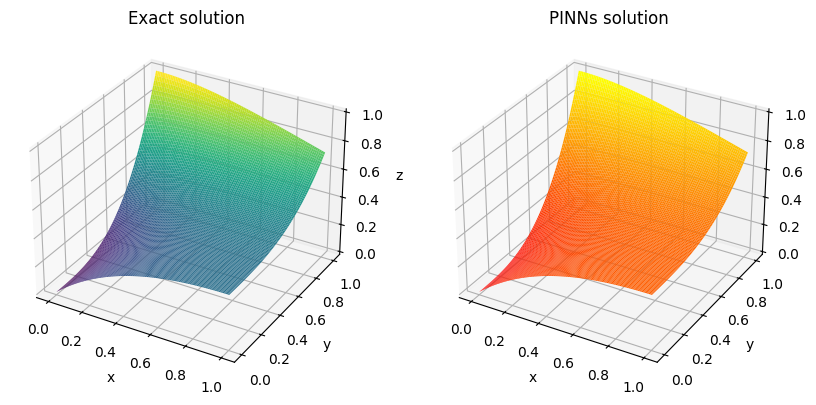

In [263]:
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(121,projection='3d')
ax1.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('z')
ax1.set_title('Exact solution')

ax2 = fig.add_subplot(122,projection='3d')
ax2.plot_surface(X, Y, Z_pred, rstride=1, cstride=1, cmap='autumn', edgecolor='none')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('z')
ax2.set_title('PINNs solution')
plt.show()

In [264]:
error = np.abs(Z - Z_pred) #compute the absolute error  between the true and the pinn solution

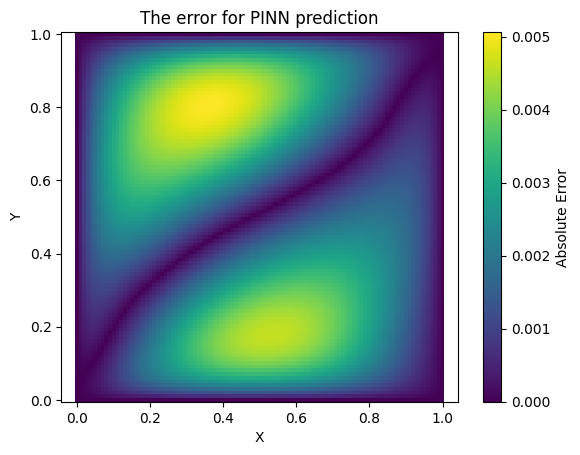

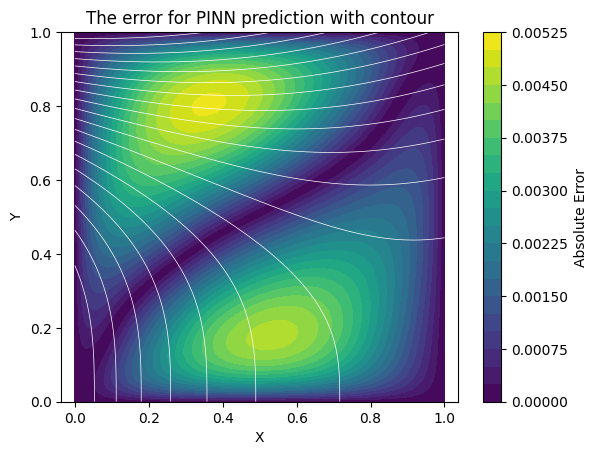

In [ ]:
plt.pcolormesh(X, Y, error, shading='auto', cmap='viridis')
plt.colorbar(label='Absolute Error')
plt.title('The error for PINN Solution')
plt.xlabel('X')
plt.ylabel('Y')
plt.axis('equal') 
plt.show()


contour = plt.contourf(X, Y, error, levels=20, cmap='viridis')

plt.contour(X, Y, Z, levels=20, colors='white', linewidths=0.5)
plt.colorbar(contour, label='Absolute Error')
plt.title('The error for PINN Solution with contour')
plt.xlabel('X')
plt.ylabel('Y')
plt.axis('equal')
plt.show()

## Problem 4
The PDE is: $$\nabla^2 \psi(x, y) + \psi(x, y)\frac{\partial}{\partial y}\psi(x, y) = \sin(\pi x)(2 - \pi^2 y^2 + 2y^3\sin(\pi x))$$
with $x, y \in [0, 1]$ and the mixed boundary conditions: $\psi(0, y) = 0$, $\psi(1, y) = 0$,and $\psi(x, 0) = 0$, $\frac{\partial}{\partial y}\psi(x, 1) = 2\sin(\pi x)$. So the trial neural form must be written as:
$$\psi_t(x, y) = A(x, y) + B(x, y)N_{part}(x, y, p)$$
where $A(x, y) = y(2\sin(\pi x))$, $B(x, y) = x(1-x)y$, $f(x,y,\psi,\nabla \psi) = \sin(\pi x)(2 - \pi^2 y^2 + 2y^3\sin(\pi x)) - \psi(x, y)\frac{\partial}{\partial y}\psi(x, y)$.

And the analytic solution is $\psi(x, y) = y^2 \sin(\pi x)$.

In [266]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #use GPU if available
print(device)


cuda


In [281]:
def A(x, y):
    ''''return (1-x)f_0(y) + xf_1(y)  + g_0(0) - [(1-x)g_0(0) + xg_0(1)] + y{g_1(x) - [(1-x)g_1(0) + xg_1(1)]}

    :x, y: 1D tensor
    psi_0y = f_0(y)
    psi_1y = f_1(y)
    psi_x0 = g_0(x)
    d_psi_x1_dy = g_1(x) = 2 * sin(pi * x)
    '''

    f_0y = 0. #psi_0y = 0.
    f_1y = 0. #psi_1y = 0.
    g_0x = 0. #psi_x0 = 0.
    g_1x = 2 * torch.sin(torch.pi * x) #d_psi_x1_dy = 2 * torch.sin(torch.pi * x)
    
    g_00 = 0.
    g_01 = 0.
    g_10 = 0.
    g_11 = 0.

    term1 = (1 - x) * f_0y
    term2 = x * f_1y
    term3 = g_0x
    term4 = (1 - x) * g_00 + x * g_01
    term5 = y * (g_1x - ((1 - x) * g_10 + x * g_11))

    A = term1 + term2 + term3 - term4 + term5

    return A

def B(x, y):
    ''''return x(1-x)y'''
    return x * (1 - x) * y

def f(x, y, psi, d_psi_dy):
    '''return sin(pi*x)*(2 - pi^2 y^2 + 2y^3 * sin(pi*x)) - Ψ(x, y)∂Ψ/∂y
    :x, y: 1D tensor
    :psi: trial solution 
    :d_psi_dy: derivative of psi(x, y) for y 
    '''

    term1 = psi * d_psi_dy
    term2 = torch.sin(torch.pi * x)
    term3 = 2 - torch.pi**2 * y**2 + 2 * y**3 * term2

    f = term2 * term3 - term1

    return f


def revised_network(X, network):
    '''return N_part(x, y, p) = N(x,y,p) - N(x,1,p) - dN(x,1,p)/dy
    :X: 2D tensor
    :network: neural network
    '''

    X1 = X.clone()
    X1[:, 1] = 1.
    #X1.requires_grad_(True)

    term1 = network(X)
    term2 = network(X1)
    term3 = torch.autograd.grad(term2, X1, grad_outputs=torch.ones_like(term2), create_graph=True)[0][:, 1].unsqueeze(1)

    #network_part = term1 - term2.detach() - term3.detach()
    network_part = term1 - term2 - term3

    return network_part


# def trial_solution_psi_2D(x, y, network_part):
#     return A(x, y) + B(x, y) * network_part


In [282]:
def calculate_loss(network):
    """
    compute the MSE loss for PINN, namely MSE(∇^2Ψ(x, y), f(x, y, Ψ(x, y), ∂Ψ/∂y))
    x, y in [0, 1]
    :network: Neural network
    """

    X = torch.rand(2048, 2, requires_grad=True).to(device)

    revised_network_part= revised_network(X, network)

    x_collocation = X[:, 0].unsqueeze(1)
    y_collocation = X[:, 1].unsqueeze(1)

    #network_value = revised_network(X, network_part)

    psi_t = trial_solution_psi_2D(x_collocation, y_collocation, revised_network_part)
    
    fist_grad = torch.autograd.grad(psi_t, X, grad_outputs=torch.ones_like(psi_t), create_graph=True)[0]

    d_psi_dx = fist_grad[:, 0].unsqueeze(1)
    d_psi_dy = fist_grad[:, 1].unsqueeze(1)

    #d_psi_dx = torch.autograd.grad(psi_t, X, grad_outputs=torch.ones_like(psi_t), create_graph=True)[0][:, 0]
    d2_psi_dx2 = torch.autograd.grad(d_psi_dx, X, grad_outputs=torch.ones_like(d_psi_dx), create_graph=True)[0][:, 0].unsqueeze(1)

    #d_psi_dy = torch.autograd.grad(psi_t, X, grad_outputs=torch.ones_like(psi_t), create_graph=True)[0][:, 1]
    d2_psi_dy2 = torch.autograd.grad(d_psi_dy, X, grad_outputs=torch.ones_like(d_psi_dy), create_graph=True)[0][:, 1].unsqueeze(1)

    residual = d2_psi_dx2 + d2_psi_dy2 - f(x_collocation, y_collocation, psi_t, d_psi_dy)

    loss = torch.mean(residual**2)

    return loss#, term1, term2, term3#, psi_t, A, B,d2_psi_dx2

In [283]:
pinn_net = NeuralNetwork(input_dim=2).to(device)
optimizer = torch.optim.AdamW(pinn_net.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10000, gamma=0.9)

In [284]:
train(epochs=5000, model=pinn_net, optimizer=optimizer, scheduler=scheduler)

 10%|█         | 504/5000 [00:18<02:39, 28.15it/s]

Epoch [500/5000], Loss: 0.000246


 20%|██        | 1005/5000 [00:36<02:16, 29.36it/s]

Epoch [1000/5000], Loss: 0.000852


 30%|███       | 1505/5000 [00:54<02:11, 26.50it/s]

Epoch [1500/5000], Loss: 0.000488


 40%|████      | 2004/5000 [01:12<01:48, 27.69it/s]

Epoch [2000/5000], Loss: 0.000329


 50%|█████     | 2505/5000 [01:30<01:34, 26.50it/s]

Epoch [2500/5000], Loss: 0.000090


 60%|██████    | 3005/5000 [01:47<01:06, 29.83it/s]

Epoch [3000/5000], Loss: 0.000210


 70%|███████   | 3505/5000 [02:05<00:51, 29.02it/s]

Epoch [3500/5000], Loss: 0.001406


 80%|████████  | 4003/5000 [02:22<00:34, 28.54it/s]

Epoch [4000/5000], Loss: 0.000428


 90%|█████████ | 4504/5000 [02:40<00:17, 28.76it/s]

Epoch [4500/5000], Loss: 0.000801


100%|██████████| 5000/5000 [02:57<00:00, 28.13it/s]

Epoch [5000/5000], Loss: 0.000082


In [285]:
def exact_solution(x, y):
    return y**2 * np.sin(np.pi * x)

x_test = torch.linspace(0, 1, 100).reshape(-1, 1)
y_test = torch.linspace(0, 1, 100).reshape(-1, 1)

X, Y = np.meshgrid(x_test.numpy(), y_test.numpy())
Z = exact_solution(X, Y)

xy_grid_flat = np.c_[X.ravel(), Y.ravel()]
xy_tensor = torch.tensor(xy_grid_flat, dtype=torch.float32,requires_grad=True, device=device)


revised_network_part = revised_network(xy_tensor, pinn_net)
#pinn_net.eval()
#with torch.no_grad():
psi_pred = trial_solution_psi_2D(xy_tensor[:, 0].reshape(-1, 1), xy_tensor[:, 1].reshape(-1, 1), revised_network_part)

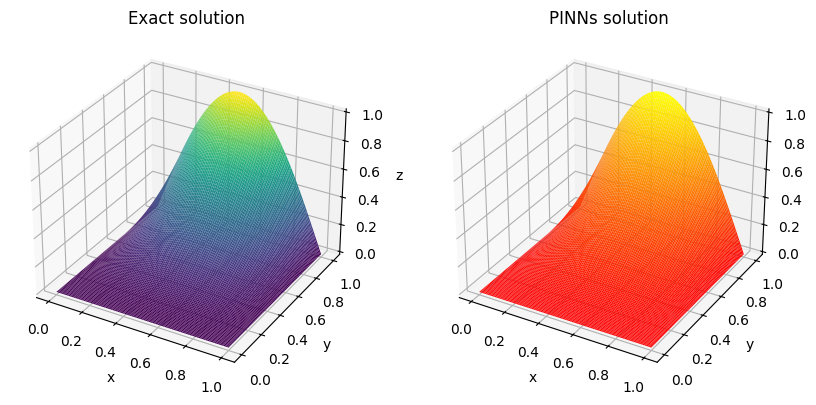

In [ ]:
Z_pred = psi_pred.cpu().detach().numpy().reshape(X.shape)
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(121,projection='3d')
ax1.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('z')
ax1.set_title('Exact solution')

ax2 = fig.add_subplot(122,projection='3d')
ax2.plot_surface(X, Y, Z_pred, rstride=1, cstride=1, cmap='autumn', edgecolor='none')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('z')
ax2.set_title('PINNs solution')
plt.show()

In [288]:
error = np.abs(Z - Z_pred)

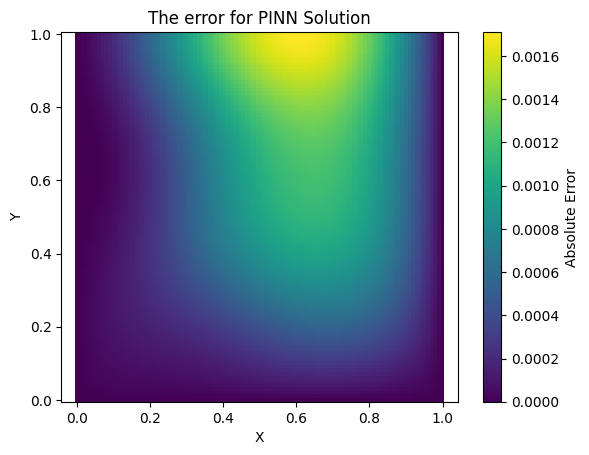

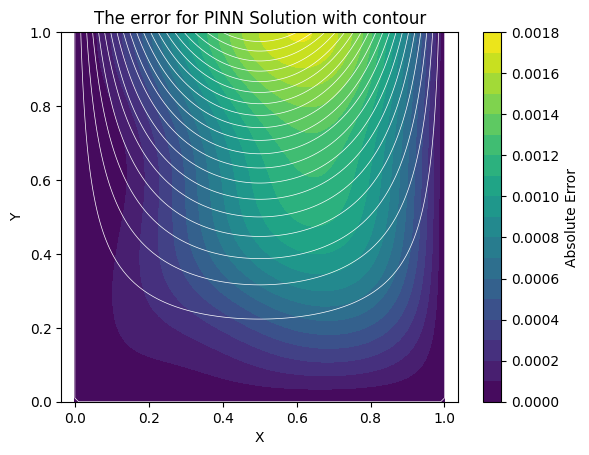

In [289]:
plt.pcolormesh(X, Y, error, shading='auto', cmap='viridis')
plt.colorbar(label='Absolute Error')
plt.title('The error for PINN Solution')
plt.xlabel('X')
plt.ylabel('Y')
plt.axis('equal') 
plt.show()


contour = plt.contourf(X, Y, error, levels=20, cmap='viridis')

plt.contour(X, Y, Z, levels=20, colors='white', linewidths=0.5)
plt.colorbar(contour, label='Absolute Error')
plt.title('The error for PINN Solution with contour')
plt.xlabel('X')
plt.ylabel('Y')
plt.axis('equal')
plt.show()

# Solve the PDEs using soft constraints

In this part, we will use PINN with soft constraints to solve the Problem 4. For a typical neural network, we incorporate physical constraints, and construct the loss function with boundary conditions and PDE constraints. So overall loss function can be written as: $$Loss = loss_{boundary} + loss_{PDE}$$
with $loss_{boundary} = [\psi(0, y) - 0]^2 + [\psi(1, y) - 0]^2 + [\psi(x, 0) - 0]^2 + [\frac{\partial}{\partial y}\psi(x, 1) - 2 \sin(\pi x)]^2$ and $loss_{PDE} = [\nabla^2 \psi(x, y) + \psi(x, y)\frac{\partial}{\partial y}\psi(x, y) - \sin(\pi x)(2 - \pi^2 y^2 + 2y^3\sin(\pi x))]^2$. Then minimizing Loss.


In [292]:
pinn_net = NeuralNetwork(input_dim=2).to(device)
optimizer = torch.optim.Adam(pinn_net.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10000, gamma=0.9)

In [293]:
epochs = 10000
for epoch in tqdm(range(epochs)):

    X_glob = torch.rand(4096, 2, requires_grad=True, device=device)
    optimizer.zero_grad()

    psi = pinn_net(X_glob)
    grads = torch.autograd.grad(psi, X_glob, torch.ones_like(psi), create_graph=True)[0]
    d_psi_dx, d_psi_dy = grads[:, 0].unsqueeze(1), grads[:, 1].unsqueeze(1)

    d2_psi_dx2 = torch.autograd.grad(d_psi_dx, X_glob, torch.ones_like(d_psi_dx), create_graph=True)[0][:, 0].unsqueeze(1)
    d2_psi_dy2 = torch.autograd.grad(d_psi_dy, X_glob, torch.ones_like(d_psi_dy), create_graph=True)[0][:, 1].unsqueeze(1)

    #boundary point sampling
    X_0y = torch.rand(512, 2, device=device)
    X_0y[:, 0] = 0.0
    X_0y_new = X_0y
    X_0y_new.requires_grad_(True)
    psi_0y = pinn_net(X_0y_new)

    X_1y = torch.rand(512, 2, device=device)
    X_1y[:, 0] = 1.0
    X_1y_new = X_1y
    X_1y_new.requires_grad_(True)
    psi_1y = pinn_net(X_1y_new)

    X_x0 = torch.rand(512, 2, device=device)
    X_x0[:, 1] = 0.0
    X_x0_new = X_x0
    X_x0_new.requires_grad_(True)   
    psi_x0 = pinn_net(X_x0_new)

    X_x1 = torch.rand(512, 2, device=device)
    X_x1[:, 1] = 1.0
    X_x1_new = X_x1
    X_x1_new.requires_grad_(True)
    psi_x1 = pinn_net(X_x1_new)


    #Dirichlet boundary conditions
    loss1 = nn.MSELoss()(psi_0y, torch.zeros_like(psi_0y))
    loss2 = nn.MSELoss()(psi_1y, torch.zeros_like(psi_1y))
    loss3 = nn.MSELoss()(psi_x0, torch.zeros_like(psi_x0))

    #Neumann boundary conditions
    d_psi_x1_dy = torch.autograd.grad(psi_x1, X_x1_new, torch.ones_like(psi_x1), create_graph=True)[0][:, 1].unsqueeze(1)
    loss4 = nn.MSELoss()(d_psi_x1_dy, (2 * torch.sin(torch.pi * X_x1_new[:, 0])).unsqueeze(1))

    #PDE
    pde_left = d2_psi_dx2 + d2_psi_dy2 + psi * d_psi_dy
    pde_right = torch.sin(torch.pi * X_glob[:, 0]) * (2 - torch.pi**2 * X_glob[:, 1]**2 + 2 * X_glob[:, 1]**3 * torch.sin(torch.pi * X_glob[:, 0]))
    pde_right = pde_right.unsqueeze(1)

    loss5 = nn.MSELoss()(pde_left, pde_right)

    loss = (loss1 + loss2 + loss3)*1 + loss4*1 + loss5

    loss.backward()
    optimizer.step()
    scheduler.step()
    
    if (epoch + 1) % 1000 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.6f}")


 10%|█         | 1010/10000 [00:13<02:01, 74.06it/s]

Epoch [1000/10000], Loss: 0.001162


 20%|██        | 2007/10000 [00:27<01:58, 67.57it/s]

Epoch [2000/10000], Loss: 0.002361


 30%|███       | 3009/10000 [00:41<01:40, 69.80it/s]

Epoch [3000/10000], Loss: 0.000571


 40%|████      | 4008/10000 [00:55<01:20, 74.17it/s]

Epoch [4000/10000], Loss: 0.000534


 50%|█████     | 5008/10000 [01:08<01:09, 72.31it/s]

Epoch [5000/10000], Loss: 0.002467


 60%|██████    | 6008/10000 [01:21<00:50, 78.32it/s]

Epoch [6000/10000], Loss: 0.000406


 70%|███████   | 7008/10000 [01:35<00:40, 74.67it/s]

Epoch [7000/10000], Loss: 0.001020


 80%|████████  | 8008/10000 [01:48<00:26, 74.22it/s]

Epoch [8000/10000], Loss: 0.001494


 90%|█████████ | 9008/10000 [02:02<00:13, 73.41it/s]

Epoch [9000/10000], Loss: 0.000253


100%|██████████| 10000/10000 [02:15<00:00, 73.85it/s]

Epoch [10000/10000], Loss: 0.000185


In [294]:
x_range = np.linspace(0, 1, 100)
y_range = np.linspace(0, 1, 100)
X, Y = np.meshgrid(x_range, y_range)
xy_grid_flat_cpu = np.c_[X.ravel(), Y.ravel()]
xy_tensor_cpu = torch.tensor(xy_grid_flat_cpu, dtype=torch.float32)
xy_tensor_gpu = xy_tensor_cpu.to(device)

In [295]:
pinn_net.eval()
with torch.no_grad():
    psi_pred_gpu = pinn_net(xy_tensor_gpu)
    
psi_pred_cpu = psi_pred_gpu.cpu()
Z_pred = psi_pred_cpu.numpy().reshape(X.shape)

def exact_solution(x, y):
    return y**2 * np.sin(np.pi * x)

Z_true = exact_solution(X, Y)
error = np.abs(Z_pred - Z_true)

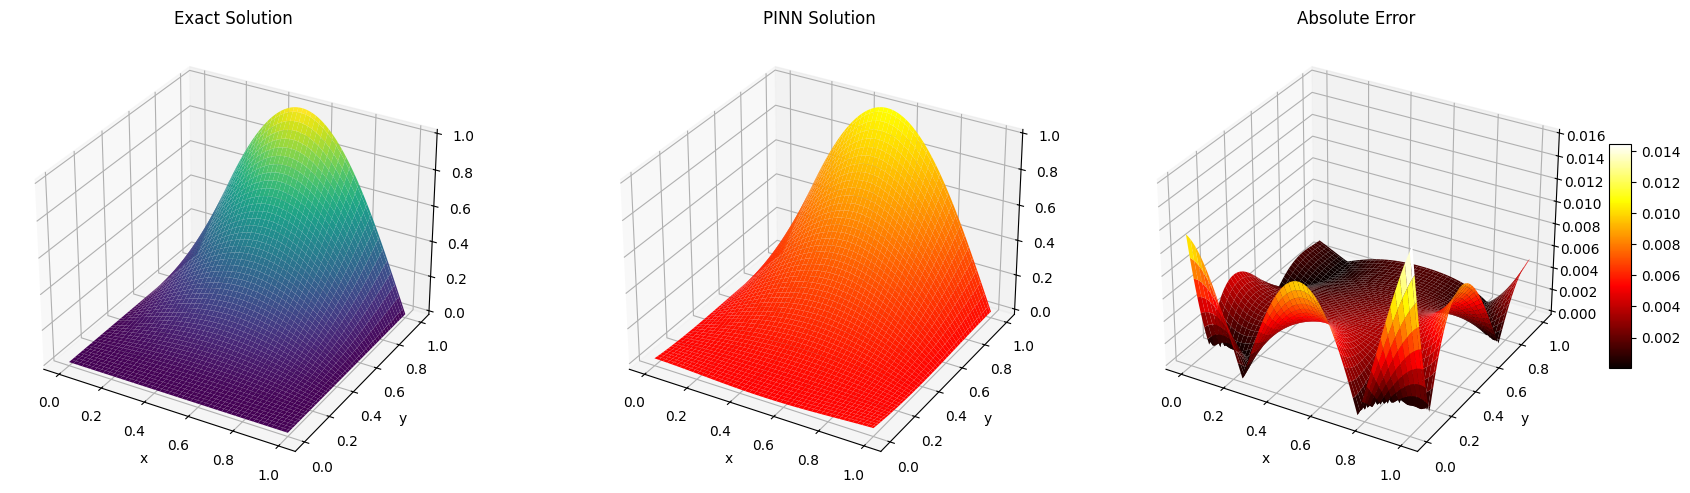

In [297]:
fig = plt.figure(figsize=(18, 5))
ax1 = fig.add_subplot(131, projection='3d')
ax1.plot_surface(X, Y, Z_true, cmap=cm.viridis)
ax1.set_title('Exact Solution')
ax1.set_xlabel('x'); ax1.set_ylabel('y')
ax2 = fig.add_subplot(132, projection='3d')
ax2.plot_surface(X, Y, Z_pred, cmap=cm.autumn)
ax2.set_title('PINN Solution')
ax2.set_xlabel('x'); ax2.set_ylabel('y')
ax3 = fig.add_subplot(133, projection='3d')
surf_error = ax3.plot_surface(X, Y, error, cmap=cm.hot)
ax3.set_title('Absolute Error')
ax3.set_xlabel('x'); ax3.set_ylabel('y')
fig.colorbar(surf_error, ax=ax3, shrink=0.5, aspect=10)
plt.tight_layout()
plt.show()

By analyzing the results of Problem 1 and Problem 2, we found that the results of PINN within the training range can well match the actual solution, but the prediction results outside the training range are relatively poor. 

For both soft and hard constraints, they get good results, and the results of hard constraints at the boundary are better than those of soft constraints.

# Reference
[1] I. E. Lagaris, A. Likas, and D. I. Fotiadis, "Artificial neural networks for solving ordinary and partial differential equations," IEEE Trans. Neural Netw. 9, 987 (1998). 

